In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/Dataset'

Mounted at /content/gdrive
/content/gdrive/MyDrive/Dataset


In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import metrics
from prettytable import PrettyTable

# Đọc dữ liệu
data = pd.read_csv('student-por.csv')

# Hiển thị thông tin dữ liệu
print(data.info())

# Mã hóa các biến categorical
categorical_features = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
numerical_features = data.columns.difference(categorical_features + ['G1', 'G2', 'G3'])

# Định nghĩa các transformer cho categorical và numerical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Tạo column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Chia dữ liệu
X = data.drop(['G3'], axis=1)
y = data['G3']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Áp dụng tiền xử lý dữ liệu
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)








<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

In [37]:
# Huấn luyện mô hình RandomForest
rf = RandomForestRegressor()
rf.fit(X_train_transformed, y_train)

# Tạo GridSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5,10],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [ 'sqrt', 'log2']
}

grid_search_RDforest = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, error_score='raise')

# Huấn luyện mô hình với GridSearchCV
grid_search_RDforest.fit(X_train_transformed, y_train)
print(f"Best parameters: {grid_search_RDforest.best_params_}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [36]:
mlp = MLPRegressor()

# Định nghĩa các tham số cần tinh chỉnh
param_grid = {
 'hidden_layer_sizes': [(100,50), (100,100)],
 'max_iter': [500],
 'activation': ['tanh', 'relu'],
 'solver': ['sgd', 'adam'],
 'alpha': [0.0001, 0.05],
 'learning_rate': ['constant','adaptive'],
}

# Tạo đối tượng GridSearchCV
grid_search_Mlp = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, error_score='raise')

# Huấn luyện mô hình với GridSearchCV

grid_search_Mlp.fit(X_train_transformed, y_train)
print(f"Best parameters MLP: {grid_search_Mlp.best_params_}")

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters MLP: {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'max_iter': 500, 'solver': 'adam'}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [42]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

classifiers = {
    'MLPClassifier':grid_search_Mlp,
    'Random Forest':grid_search_RDforest,

}
# Tạo dictionary để lưu trữ các kết quả
results = {}
for name, clf in classifiers.items():
    y_pred = clf.predict(X_test_transformed)

    # Tính các chỉ số hồi quy
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results[name] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}

# Tạo bảng kết quả
table = PrettyTable()
table.field_names = ["Algorithm", "MAE", "MSE", "RMSE", "R2"]
for name, metrics in results.items():
    table.add_row([name, metrics['MAE'], metrics['MSE'], metrics['RMSE'], metrics['R2']])
print(table)


+---------------+--------------------+-------------------+--------------------+-----------------------+
|   Algorithm   |        MAE         |        MSE        |        RMSE        |           R2          |
+---------------+--------------------+-------------------+--------------------+-----------------------+
| MLPClassifier | 2.463689394242509  | 9.812063792087534 | 3.1324213943988335 | -0.006188430416005142 |
| Random Forest | 1.9796586795291755 | 7.312502480720052 | 2.704163915283253  |   0.2501317205640101  |
+---------------+--------------------+-------------------+--------------------+-----------------------+


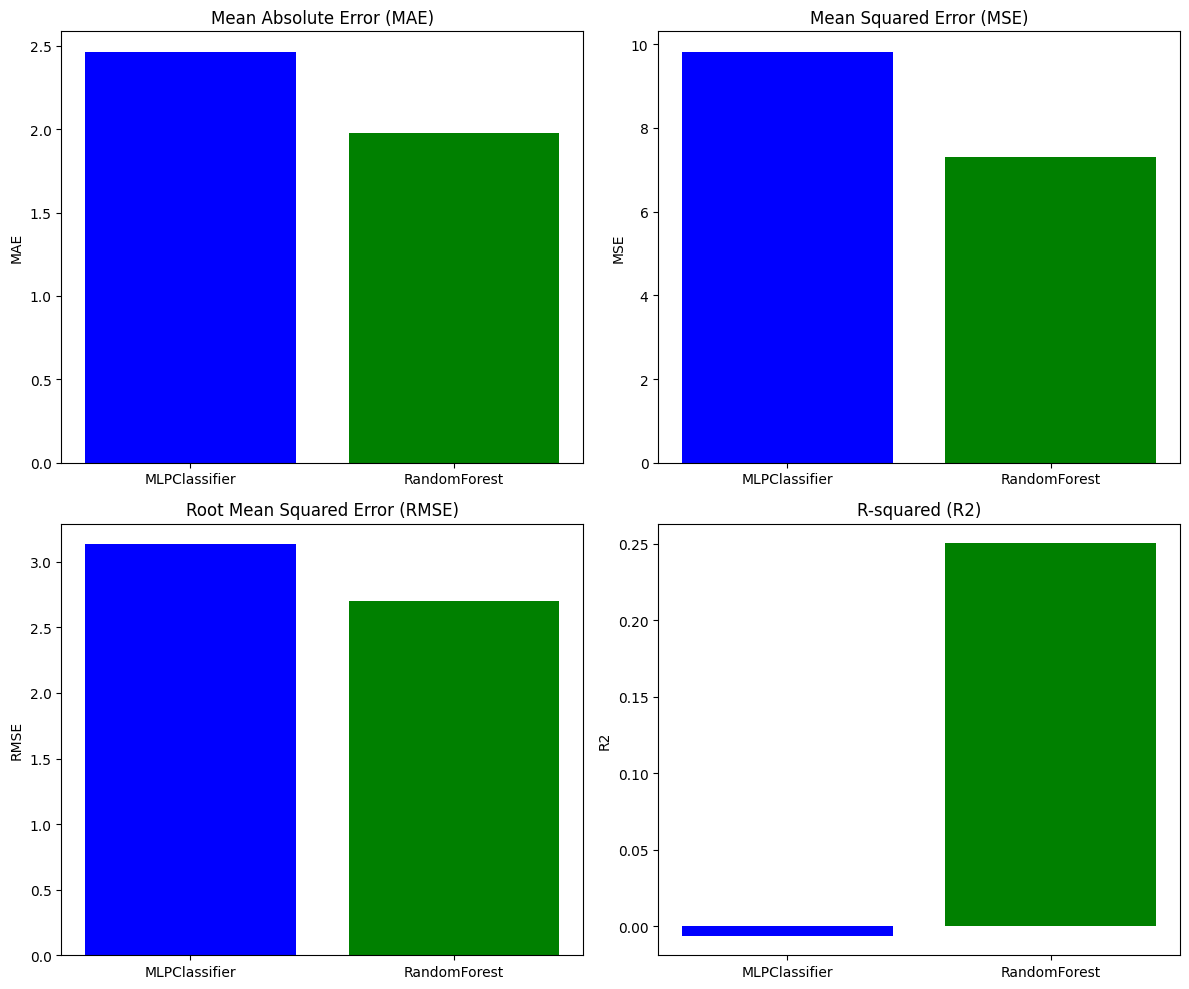

In [43]:
models = ['MLPClassifier', 'RandomForest']
mae = [2.463689, 1.979659]
mse = [9.812064, 7.312502]
rmse = [3.132421, 2.704164]
r2 = [-0.006188, 0.250132]

# Vẽ biểu đồ
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# MAE
ax[0, 0].bar(models, mae, color=['blue', 'green'])
ax[0, 0].set_title('Mean Absolute Error (MAE)')
ax[0, 0].set_ylabel('MAE')

# MSE
ax[0, 1].bar(models, mse, color=['blue', 'green'])
ax[0, 1].set_title('Mean Squared Error (MSE)')
ax[0, 1].set_ylabel('MSE')

# RMSE
ax[1, 0].bar(models, rmse, color=['blue', 'green'])
ax[1, 0].set_title('Root Mean Squared Error (RMSE)')
ax[1, 0].set_ylabel('RMSE')

# R2
ax[1, 1].bar(models, r2, color=['blue', 'green'])
ax[1, 1].set_title('R-squared (R2)')
ax[1, 1].set_ylabel('R2')

plt.tight_layout()
plt.show()